# **CUSTOMER PROFILE FOR UNITED STATES CYCLING INDUSTRY USING K-MEANS AND RFM MODEL**

#### Import necessary libraries

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
import datetime as dt
from sklearn.metrics import silhouette_score, accuracy_score

import warnings 
warnings.filterwarnings('ignore')

In [71]:
import lifetimes
from lifetimes import GammaGammaFitter
from scipy.stats import gamma, beta
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *

#### Loading dataset

In [72]:
# data
sales_df_raw = pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Sales_data')

date_df_raw = pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Date_data')

product_df_raw= pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Product_data')

customer_df_raw = pd.read_excel('AdventureWorks Sales_raw.xlsx', sheet_name='Customer_data')

In [73]:
sales_df = sales_df_raw[['SalesOrderLineKey','CustomerKey','ProductKey','OrderDateKey','Order Quantity','Sales Amount']]
sales_df.shape

(121253, 6)

In [74]:
product_df = product_df_raw[['ProductKey','Product','Model','Subcategory','Category']]
product_df = product_df[product_df['Category'] == 'Bikes']
product_df.shape

(125, 5)

In [75]:
#keep columns DateKey, Date
date_df = date_df_raw[['DateKey','Date']]
date_df = date_df.rename(columns={'DateKey': 'OrderDateKey'})
date_df.shape

(1461, 2)

In [76]:
#delete value -1 of CustomerKey and columns Postal Code and Customer ID
customer_df_raw = customer_df_raw[customer_df_raw['CustomerKey'] != -1]
customer_df_raw = customer_df_raw[customer_df_raw['Country-Region'] == 'United States']
customer_df = customer_df_raw.drop(columns=['Postal Code','Customer ID'])

customer_df.shape

(7819, 5)

#### Data Engineering
create the dataframe for RFM model

In [77]:
aw_df = pd.merge(left=sales_df, right=product_df,on='ProductKey')
aw_df = pd.merge(left=aw_df, right=date_df, on='OrderDateKey')
aw_df = pd.merge(left=aw_df, right=customer_df, on='CustomerKey')

aw_df.head()

,SalesOrderLineKey,CustomerKey,ProductKey,OrderDateKey,Order Quantity,Sales Amount,Product,Model,Subcategory,Category,Date,Customer,City,State-Province,Country-Region
0,43711001,27606,314,20170702,1,"3,578.270","Road-150 Red, 56",Road-150,Road Bikes,Bikes,2017-07-02,Courtney Edwards,Milwaukie,Oregon,United States
1,71134001,27606,563,20200421,1,"2,384.070","Touring-1000 Yellow, 54",Touring-1000,Touring Bikes,Bikes,2020-04-21,Courtney Edwards,Milwaukie,Oregon,United States
2,43706001,27621,312,20170702,1,"3,578.270","Road-150 Red, 48",Road-150,Road Bikes,Bikes,2017-07-02,Edward Brown,Santa Monica,California,United States
3,71203001,27621,561,20200422,1,"2,384.070","Touring-1000 Yellow, 46",Touring-1000,Touring Bikes,Bikes,2020-04-22,Edward Brown,Santa Monica,California,United States
4,43707001,27616,312,20170702,1,"3,578.270","Road-150 Red, 48",Road-150,Road Bikes,Bikes,2017-07-02,Emma Brown,Lemon Grove,California,United States


In [78]:
aw_df = aw_df.dropna()
aw_df.isnull().sum()

SalesOrderLineKey    0
CustomerKey          0
ProductKey           0
OrderDateKey         0
Order Quantity       0
Sales Amount         0
Product              0
Model                0
Subcategory          0
Category             0
Date                 0
Customer             0
City                 0
State-Province       0
Country-Region       0
dtype: int64

In [79]:
aw_df=aw_df.drop_duplicates()

In [80]:
recent_day = aw_df['Date'].max()
min_day = aw_df['Date'].min()
min_day, recent_day

(Timestamp('2017-07-01 00:00:00'), Timestamp('2020-05-30 00:00:00'))

Days 1064
Years, Months, Days
2, 10, 29

In [81]:
from datetime import timedelta

In [82]:
aw_df = aw_df[['CustomerKey','Date','Sales Amount']]
aw_df

,CustomerKey,Date,Sales Amount
0,27606,2017-07-02,"3,578.270"
1,27606,2020-04-21,"2,384.070"
2,27621,2017-07-02,"3,578.270"
3,27621,2020-04-22,"2,384.070"
4,27616,2017-07-02,"3,578.270"
...,...,...,...
4902,22116,2019-10-29,539.990
4903,20028,2019-10-29,"1,120.490"
4904,17121,2019-10-29,"1,700.990"
4905,22153,2019-10-29,539.990


## 2. BG/ Negative Binomial Distribution NBD
2.1 Train/Test Split

In [83]:
df_summary = lifetimes.utils.summary_data_from_transaction_data(
    transactions = aw_df, 
    customer_id_col = "CustomerKey", 
    datetime_col = "Date", 
    monetary_value_col = "Sales Amount", 
    observation_period_end = recent_day, 
    freq = "D")
df_summary = pd.DataFrame(df_summary)
df_summary

,frequency,recency,T,monetary_value
CustomerKey,,,,
11015,0.000,0.000,344.000,0.000
11016,0.000,0.000,322.000,0.000
11021,0.000,0.000,339.000,0.000
11022,0.000,0.000,342.000,0.000
11036,0.000,0.000,340.000,0.000
...,...,...,...,...
29334,0.000,0.000,867.000,0.000
29335,0.000,0.000,866.000,0.000
29350,0.000,0.000,866.000,0.000


In [84]:
df_summary['frequency'].value_counts()

0.000    2241
1.000    1318
2.000      10
Name: frequency, dtype: int64

In [85]:
df_summary['monetary_value'].value_counts()

0.000        2241
2,294.990     311
2,319.990     302
2,384.070     229
769.490       201
742.350       124
1,214.850      74
539.990        30
564.990        26
1,700.990      10
1,120.490      10
1,518.670       6
1,531.170       4
2,443.350       1
Name: monetary_value, dtype: int64

In [86]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
        frequency = df_summary["frequency"], 
        recency = df_summary["recency"], 
        T = df_summary["T"] ,
        weights = None,  
        verbose = True,   
        tol = 1e-06
        )
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary


Optimization terminated successfully.
         Current function value: 0.378589
         Iterations: 38
         Function evaluations: 39
         Gradient evaluations: 39


,coef,se(coef),lower 95% bound,upper 95% bound
r,3.005,0.170,2.672,3.339
alpha,"2,653.332",159.753,"2,340.216","2,966.448"
a,0.051,0.356,-0.647,0.749
b,0.002,0.016,-0.029,0.034


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

<Figure size 864x864 with 0 Axes>

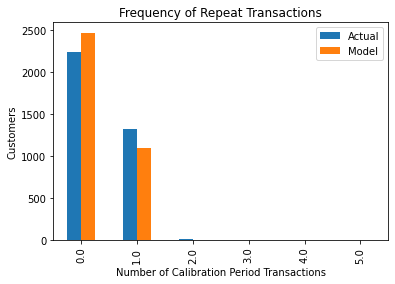

In [87]:
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10)

In [88]:
# train/test split (calibration/holdout)
t_holdout = 30                                       # 30 days to reserve for holdout period

max_date = recent_day                  # end date of observations/ max date of the dataset
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period/ cutoff
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = aw_df, 
        customer_id_col = "CustomerKey", 
        datetime_col = "Date",
        monetary_value_col = "Sales Amount", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date,         
        freq = "D")  # D for days, W for weeks

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2020-05-30 00:00:00
end of calibration period: 2020-04-30 00:00:00
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerKey,,,,,,,
11015,0,0,314,0,0,0,30
11016,0,0,292,0,0,0,30
11021,0,0,309,0,0,0,30
11022,0,0,312,0,0,0,30
11036,0,0,310,0,0,0,30
...,...,...,...,...,...,...,...
29334,0,0,837,0,0,0,30
29335,0,0,836,0,0,0,30
29350,0,0,836,0,0,0,30


In [89]:
df_ch.describe()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
count,"3,288","3,288","3,288","3,288","3,288","3,288","3,288"
mean,0,190,406,668,0,57,30
std,0,275,312,978,0,324,0
min,0,0,0,0,0,0,30
25%,0,0,132,0,0,0,30
50%,0,0,326,0,0,0,30
75%,1,427,684,"1,215",0,0,30
max,2,"1,026","1,034","2,443",1,"2,384",30


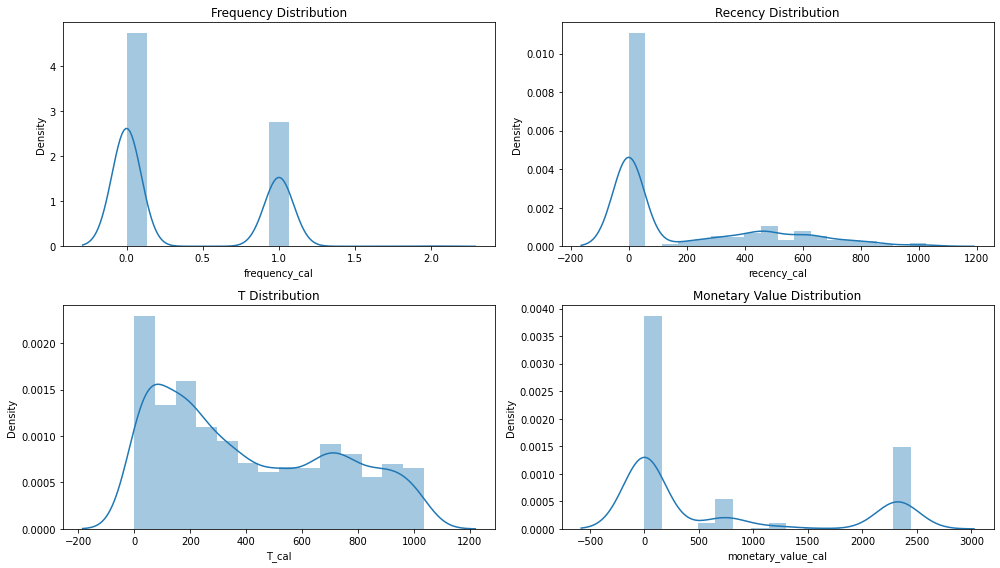

In [90]:
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(df_ch["frequency_cal"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(df_ch["recency_cal"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(df_ch["T_cal"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(df_ch["monetary_value_cal"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

2.2 Fit the BG/NBD Model

In [91]:
# training: BG/NBD model
bgf = BetaGeoFitter(penalizer_coef= 1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06
        )

Optimization terminated successfully.
         Current function value: 0.350989
         Iterations: 45
         Function evaluations: 46
         Gradient evaluations: 46


<lifetimes.BetaGeoFitter: fitted with 3288 subjects, a: 1.68, alpha: 27349.31, b: 0.04, r: 28.77>

In [92]:
# training: summary
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,28.769,5.250,18.480,39.059
alpha,"27,349.305","5,024.394","17,501.493","37,197.118"
a,1.677,8.182,-14.361,17.714
b,0.041,0.201,-0.352,0.434


<Figure size 864x864 with 0 Axes>

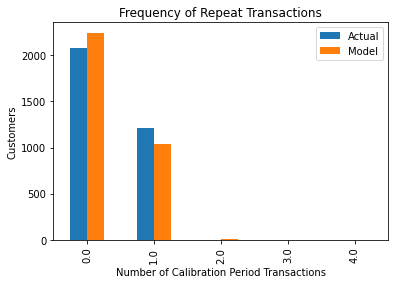

In [93]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

<Figure size 504x504 with 0 Axes>

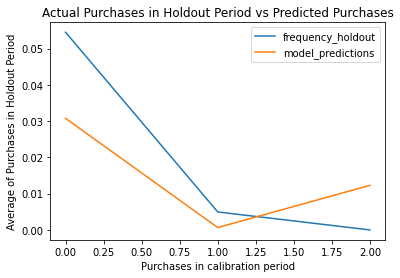

In [94]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch)

# 3. Predict the number of purchase in the next period

3.3 Predictions

In [95]:
# First, we choose a sample customer. 
sample_customer = df_ch.iloc[20] 

# Let's inspect his frequency, recency and T both for the calibration and observation periods:
sample_customer

frequency_cal              0.000
recency_cal                0.000
T_cal                    307.000
monetary_value_cal         0.000
frequency_holdout          0.000
monetary_value_holdout     0.000
duration_holdout          30.000
Name: 11144, dtype: float64

In [96]:
# This function calculates the conditional expected number of transactions in the given time length
n_transactions_pred = bgf.predict(t=t_holdout, # we set it to 360 days (the length of the observation period)
                                  frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])

n_transactions_pred 

0.030720755031338767

In [97]:
df_ch['predicted_purchased'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t=30,
    frequency=sample_customer['frequency_cal'], 
    recency=sample_customer['recency_cal'], 
    T=sample_customer['T_cal']
)
df_ch.sort_values(by='predicted_purchased')

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchased
CustomerKey,,,,,,,,
11015,0.000,0.000,314.000,0.000,0.000,0.000,30.000,0.031
23269,0.000,0.000,124.000,0.000,0.000,0.000,30.000,0.031
23270,0.000,0.000,118.000,0.000,0.000,0.000,30.000,0.031
23276,0.000,0.000,140.000,0.000,0.000,0.000,30.000,0.031
23287,0.000,0.000,119.000,0.000,0.000,0.000,30.000,0.031
...,...,...,...,...,...,...,...,...
16888,0.000,0.000,293.000,0.000,0.000,0.000,30.000,0.031
16889,0.000,0.000,263.000,0.000,0.000,0.000,30.000,0.031
16890,0.000,0.000,259.000,0.000,0.000,0.000,30.000,0.031


In [98]:
alive_prob = bgf.conditional_probability_alive(frequency=sample_customer['frequency_cal'], 
                                               recency=sample_customer['recency_cal'], 
                                               T=sample_customer['T_cal'])

alive_prob

array([1.])

In [99]:
# the real number of transactions in the observation period, which equals frequency_holdout + 1
df_ch["n_transactions_holdout_real"]  = df_ch["frequency_holdout"] + 1

# the predicted number of transactions in the next 360 days (length of the observation period)
df_ch["n_transactions_holdout_pred"] = bgf.predict(t=360, 
                                                    frequency=df_ch['frequency_cal'], 
                                                    recency=df_ch['recency_cal'], 
                                                    T=df_ch['T_cal'])

# comparison of the real and predicted transactions
df_ch[["n_transactions_holdout_real", "n_transactions_holdout_pred"]].head()

,n_transactions_holdout_real,n_transactions_holdout_pred
CustomerKey,,
11015,1.000,0.312
11016,1.000,0.312
11021,1.000,0.312
11022,1.000,0.312
11036,1.000,0.312


In [100]:
from sklearn.metrics import mean_squared_error

In [101]:

RMSE = mean_squared_error(y_true = df_ch["n_transactions_holdout_real"],
                          y_pred = df_ch["n_transactions_holdout_pred"],
                          squared = False)

RMSE

0.8656691139925108

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

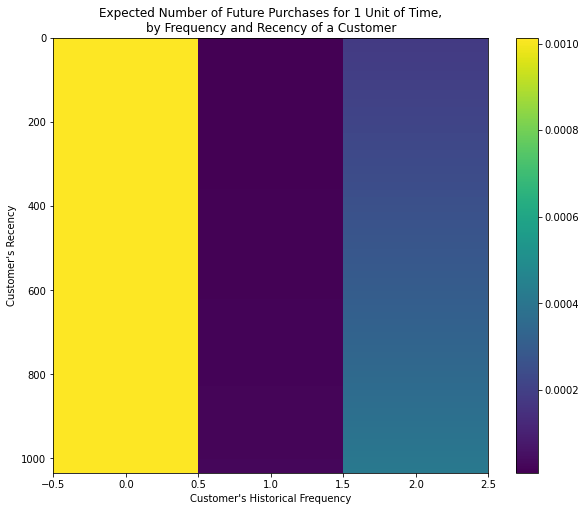

In [102]:
#plotting the frequency and recency matrix
plt.figure(figsize=(10,8))
plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

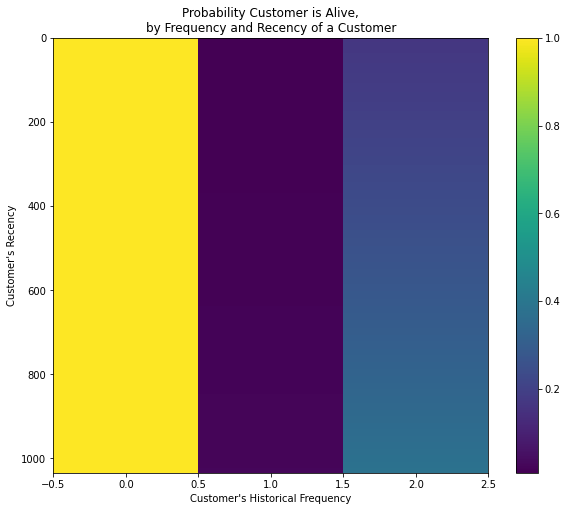

In [103]:
#plotting the churn matrix
plt.figure(figsize=(10,8))
plot_probability_alive_matrix(bgf)

In [104]:
# df_ch["exp_sales_3_month"] = bgf.predict(4 * 3,
#                                            df_ch['frequency_cal'],
#                                            df_ch['recency_cal'],
#                                            df_ch['T_cal'])
# df_ch.sort_values("exp_sales_3_month", ascending=False).head(10)

In [105]:
# df_ch["exp_sales_6_month"] = bgf.predict(4 * 6,
#                                            df_ch['frequency_cal'],
#                                            df_ch['recency_cal'],
#                                            df_ch['T_cal'])
# df_ch.sort_values("exp_sales_6_month", ascending=False).head(10)

<AxesSubplot:title={'center':'mean: 0.001, var: 0.000'}, xlabel='Transaction Rate', ylabel='Density'>

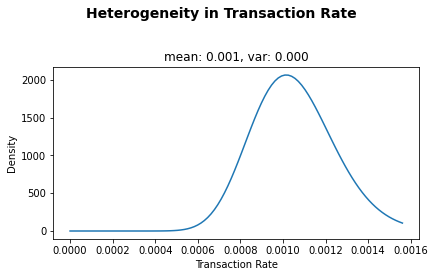

In [106]:
# plot the estimated gamma distribution of λ (customers' propensities to purchase)
plot_transaction_rate_heterogeneity(bgf)

<AxesSubplot:title={'center':'mean: 0.976, var: 0.009'}, xlabel='Dropout Probability p', ylabel='Density'>

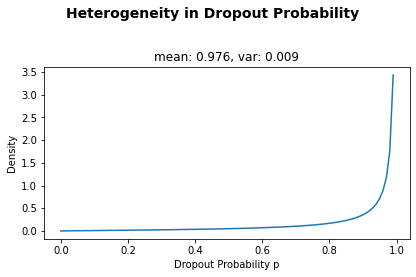

In [107]:
# Beta distribution of p: customer's probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(model = bgf)

---

# 4. GAMMA GAMMA Value Model fitting 

In [108]:
df_gmgm = df_summary[df_summary['monetary_value'] > 0]

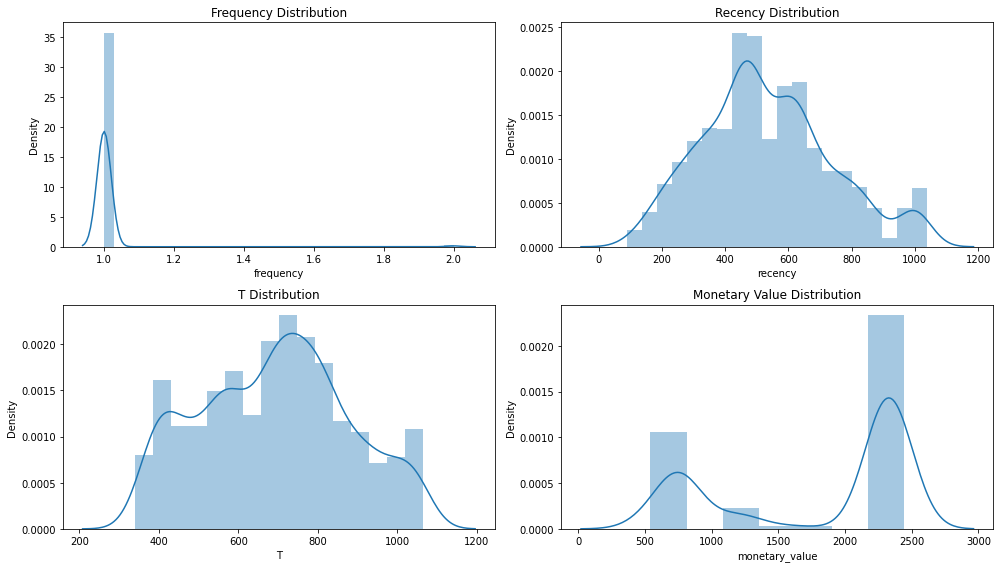

In [125]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(df_gmgm["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(df_gmgm["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(df_gmgm["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(df_gmgm["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

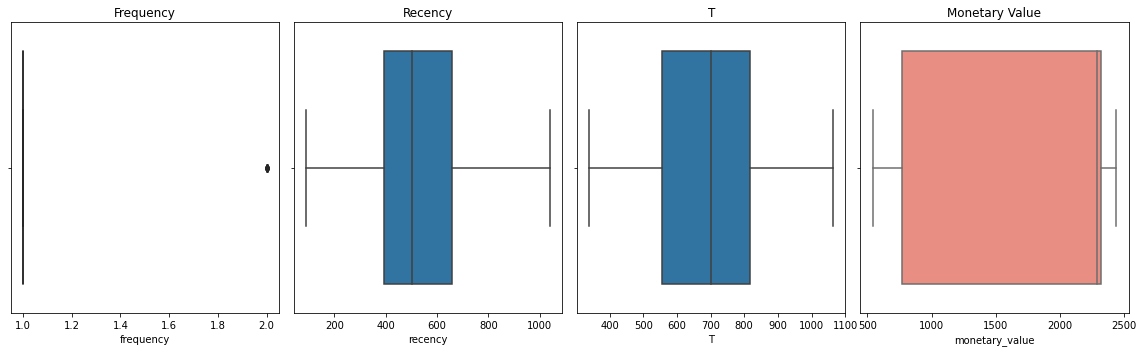

In [126]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(df_gmgm["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(df_gmgm["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(df_gmgm["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(df_gmgm["monetary_value"], color = "salmon")
plt.title("Monetary Value")
plt.tight_layout()

To proceed with the Gamma Gamma Model we have to check for the assumption whether the frequency and monetary values are intercorrelated or not. As we can see here, the correlation between the frequency and monetary value is pretty low so we can go ahead to build Gamma Gamma Model.

<AxesSubplot:>

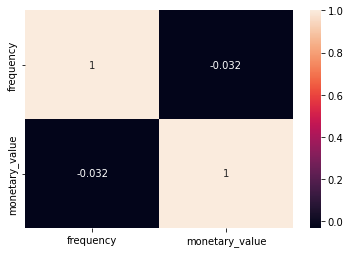

In [109]:
# Gamma-Gamma model requires a Pearson correlation close to 0 
# between purchase frequency and monetary value
sns.heatmap(df_gmgm[["frequency", "monetary_value"]].corr(), annot = True)

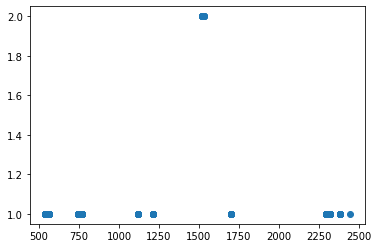

In [110]:
dfx = df_gmgm["monetary_value"]
dfy = df_gmgm["frequency"]
plt.scatter(dfx, dfy)

In [111]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_gmgm["frequency"],
        monetary_value = df_gmgm["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)

<lifetimes.GammaGammaFitter: fitted with 1328 subjects, p: 68.91, q: 3.58, v: 71.76>

In [112]:
ggf.conditional_expected_average_profit(df_gmgm['frequency'],
                                        df_gmgm['monetary_value']).sort_values(ascending=False).head(10)

CustomerKey
14081   2,424.418
27651   2,367.276
26534   2,367.276
26511   2,367.276
28191   2,367.276
28190   2,367.276
28159   2,367.276
26530   2,367.276
26532   2,367.276
26536   2,367.276
dtype: float64

In [113]:
ggf.conditional_expected_average_profit(df_gmgm['frequency'],
                                        df_gmgm['monetary_value']).sort_values(ascending=True).head(10)

CustomerKey
15862   589.689
15562   589.689
15553   589.689
15892   589.689
15570   589.689
15548   589.689
15276   589.689
15017   589.689
15901   589.689
15860   589.689
dtype: float64

In [114]:
ggf.conditional_expected_average_profit(
        df_gmgm['frequency'],
        df_gmgm['monetary_value']).mean()

1792.1151961087066

In [115]:
df_gmgm[df_gmgm['frequency']>0]['monetary_value'].mean()

1787.4495331325297

In [116]:
from sklearn.metrics import mean_absolute_percentage_error

In [117]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(df_gmgm["frequency"], df_gmgm["monetary_value"])

df_gmgm["Expected_Avg_Sales"] = exp_avg_rev
df_gmgm["avg_rev"] = df_gmgm["monetary_value"]
df_gmgm["error_rev"] = df_gmgm["Expected_Avg_Sales"] - df_gmgm["avg_rev"]

mape = mean_absolute_percentage_error(exp_avg_rev, df_gmgm["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_gmgm.head()

MAPE of predicted revenues: 0.02


,frequency,recency,T,monetary_value,Expected_Avg_Sales,avg_rev,error_rev
CustomerKey,,,,,,,
11042,1.000,269.000,341.000,742.350,784.752,742.350,42.402
11082,1.000,288.000,340.000,742.350,784.752,742.350,42.402
11083,1.000,306.000,356.000,742.350,784.752,742.350,42.402
11084,1.000,321.000,358.000,742.350,784.752,742.350,42.402
11088,1.000,303.000,349.000,742.350,784.752,742.350,42.402


In [118]:
clv = ggf.customer_lifetime_value(bgf,
                                   df_gmgm['frequency'],
                                   df_gmgm['recency'],
                                   df_gmgm['T'],
                                   df_gmgm['monetary_value'],
                                   time=6,  # 6 months
                                   freq="W",  # Tenure frequency Weekly
                                   discount_rate=0.01)

df_gmgm["clv"] = clv
clv

CustomerKey
11042   0.465
11082   0.474
11083   0.475
11084   0.482
11088   0.477
         ... 
29274   0.449
29275   0.448
29276   0.458
29278   0.457
29279   0.455
Name: clv, Length: 1328, dtype: float64

In [119]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [120]:
print("Expected Average Sales: %s" % df_gmgm["Expected_Avg_Sales"].mean())
print("Actual Average Sales: %s" % df_gmgm["monetary_value"].mean())
print("Difference: %s" % (df_gmgm["monetary_value"].mean() - df_gmgm["Expected_Avg_Sales"].mean()))
print("Mean Squared Error: %s" % mean_squared_error(df_gmgm["monetary_value"], df_gmgm["Expected_Avg_Sales"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(df_gmgm["monetary_value"], df_gmgm["Expected_Avg_Sales"])))

Expected Average Sales: 1792.1151961087066
Actual Average Sales: 1787.4495331325297
Difference: -4.665662976176918
Mean Squared Error: 712.7667179986946
Root Mean Squared Error: 26.69769124847118


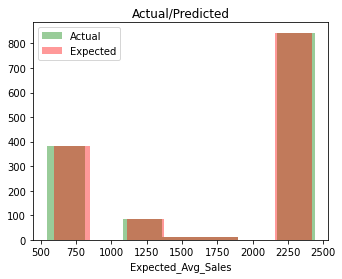

In [121]:
df_gmgm["Expected_Avg_Sales"] = ggf.conditional_expected_average_profit(df_gmgm["frequency"], 
                                                                        df_gmgm["monetary_value"])

plt.figure(figsize=(18,4))
plt.subplot(131)
sns.distplot(df_gmgm["monetary_value"], color = "g", kde = False)
sns.distplot(df_gmgm["Expected_Avg_Sales"], color = "r", kde = False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])
# plt.subplot(132)
# sns.scatterplot(df_gmgm["monetary_value"], df_gmgm["Expected_Avg_Sales"], alpha = 0.5, hue = df_gmgm["Error"], palette = "winter")
# plt.title("Actual v/s Predicted")
# plt.subplot(133)
# plt.plot(df_gmgm["monetary_value"]-df_gmgm["Expected_Avg_Sales"], color = 'r', alpha = 0.4)
# plt.title("Avg Sales Error")
# plt.show()

---